In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import pylab as plt
from glob import glob
import subprocess
import re

import geopandas
from matplotlib_scalebar.scalebar import ScaleBar

from shapely import wkt

import seaborn as sns

In [2]:
waterFloodedFile = "/Users/swise/Projects/hitomi/data/RitsurinDemo/TakamatsuWaterFlooded.shp"
waterTyphoon16File = "/Users/swise/Projects/hitomi/data/elderDemo/typhoon16ForFinalViz.shp"
roadsFile = "/Users/swise/Projects/hitomi/data/roadsProj.shp"
baseShapefileFilename = "/Users/swise/Projects/hitomi/data/RitsurinDemo/Ritsurin.shp"


In [68]:
###### a function to read in the given files
###
### files - a list of files produced by the simulation, with a header like
###         ID	age	status	evacuatingTime	flooded	x_home	y_home	
###            x_loc	y_loc	dependent	dependentOf	turnedAway
### prefix - a string indicating the tranche of simulation runs
###
### return - a DataFrame containing all of the raw data, with the scenario
###          parameters included as factors
###
def readInFiles(files, prefix):

    holder = {} # set up the holder

    for f in files: # iterate through files

        if f.startswith(myPrefix): # select the target run

            baseName = f[len(myPrefix):] # extract the metadata from the filename

            # filenames look like "sweeper_true_true_true_RitsurinDemo-TakamatsuTyphoon16.shp_5.txt"
            nameBits = baseName.split("_")

            # pull out the relevant settings
            #ageEnabled = nameBits[0] == "true"
            #neighboursEnabled = nameBits[1] == "true"
            #helpersEnabled = nameBits[2] == "true"
            #waterShapefile = nameBits[3]
            scenario = nameBits[1]
            seed = int(nameBits[2].rsplit(".")[0]) # the portion before the .txt or .csv

            # now read in the data
            raw_data = pd.DataFrame(pd.read_csv(workingDir + f, sep='\t')) # read in file

            # combo categories of status/flood outcome for individuals
            raw_data['final_status'] = raw_data['status'] + "_" + raw_data['flooded']

            # get counts in each
            #df = raw_data.groupby(['final_status']).agg({'ID': 'count', 'status': 'min', 'flooded': 'min'})

            df = raw_data

            # save the settings for these runs
            df['seed'] = seed
            #df['ageEnabled'] = ageEnabled
            #df['neighboursEnabled'] = neighboursEnabled
            #df['helpersEnabled'] = helpersEnabled
            #df['waterShapefile'] = waterShapefile
            df['scenario'] = scenario

            if(len(holder) == 0):
                holder = df
            else:
                holder = holder.append(df)
    return holder
       
    
# set up the working directory and the relevant set of projects
workingDir = "/Users/swise/Projects/hitomi/data/tsunami/output_50per/"#"/Users/swise/Projects/hitomi/data/elderDemo/output/"
myPrefix = "sweep"

# read in the list of files from the directory
files = os.listdir(workingDir)

# read in the simulation data
holder = readInFiles(files, myPrefix)

# update the time for the evacuating ones!!
holder.head() # show how the data now stands

,ID,age,status,evacuatingTime,flooded,x_home,y_home,x_loc,y_loc,dependent,dependentOf,turnedAway,final_status,seed,scenario
0,2411124001437207972,14,Evacuating,721.0,notSubmerged,963264.586504,3.810619e+06,963971.573717,3.810970e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami
1,494183244965985357,14,Evacuating,721.0,notSubmerged,964900.436316,3.812210e+06,965491.466685,3.811234e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami
2,-4531259185626685200,4,Evacuating,721.0,notSubmerged,964900.436316,3.812210e+06,965491.538617,3.811234e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami
3,2858753827684367568,13,Evacuating,721.0,notSubmerged,967754.958908,3.810030e+06,967907.873848,3.810904e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami
4,-507074620025739505,13,Evacuating,721.0,notSubmerged,967754.958908,3.810030e+06,967438.442183,3.809528e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami


In [69]:
etime = "evacuatingTime"
holder[etime] = np.where(holder['status']=="Evacuating", 780 - holder[etime], holder[etime])

In [70]:
##### create a better title for the scenarios (for use with charts)
###
### x - a DataFrame containing columns 'neighboursEnabled', 'helpersEnabled', and 'waterShapefile'
### waterData - a boolean showing whether or not to include the flooding scenario in the name
###
### return - a pandas Series of human-readable names for the associated scenarios
###
def constructName(x, waterData = True):#False):

    # define if the Neighbour setting is activated
    result = "Neighbours" # a hack to make this easier
    if not x['neighboursEnabled']:
        result = "" # if it's off, reset the title to be empty
    elif x['helpersEnabled']: # if it's not off and there's another parameter, + it!
        result += "+\n"

    # define if the Helper setting is activated        
    if x['helpersEnabled']:
        result += "Helpers"

    # if neither was turned on, just call it a "baseline" example
    if len(result) == 0:
        result = "Baseline"

    if waterData:
        # define what the water setting was
        if x['waterShapefile'].endswith('Flooded.shp'):
            result += " - Flood"
        elif x['waterShapefile'].endswith('Typhoon16.shp'):
            result += " - Typhoon 16"
        elif x['waterShapefile'].endswith('emptyFloodingFile.shp'):
            result += " - Tsunami"
        else:
            result += " - Other"
        
    # return the result
    return result

# create more attractive names
settingNames = holder.scenario#holder.apply(constructName, axis=1)

# store them
holder["settings enabled"] = settingNames
holder.head() # show how the data now stands

,ID,age,status,evacuatingTime,flooded,x_home,y_home,x_loc,y_loc,dependent,dependentOf,turnedAway,final_status,seed,scenario,settings enabled
0,2411124001437207972,14,Evacuating,59.0,notSubmerged,963264.586504,3.810619e+06,963971.573717,3.810970e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami,tsunami
1,494183244965985357,14,Evacuating,59.0,notSubmerged,964900.436316,3.812210e+06,965491.466685,3.811234e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami,tsunami
2,-4531259185626685200,4,Evacuating,59.0,notSubmerged,964900.436316,3.812210e+06,965491.538617,3.811234e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami,tsunami
3,2858753827684367568,13,Evacuating,59.0,notSubmerged,967754.958908,3.810030e+06,967907.873848,3.810904e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami,tsunami
4,-507074620025739505,13,Evacuating,59.0,notSubmerged,967754.958908,3.810030e+06,967438.442183,3.809528e+06,<none>,<none>,0,Evacuating_notSubmerged,1,tsunami,tsunami


In [5]:
tsunamiArea = "/Users/swise/Projects/hitomi/data/tsunami/notionalInundation.shp"

# transform this into spatial data
df = geopandas.read_file(tsunamiArea)
df

,full_id,osm_id,osm_type,name,waterway,geometry
0,None,None,None,None,None,"POLYGON ((955358.427 3813830.197, 955348.407 3..."


In [92]:
def selectOnAttribute(df, targetValues, waterFile = None, exclude=False):
    
    myDf = df
    
    # select on the flooding scenario?
    if waterFile is not None:
        # pull out the runs on a specific water setting
        myDf = df[df["waterShapefile"] == waterFile]

    # make sure there's actually something to select!
    if len(targetValues) == 0:
        return myDf
        
    # iterate through, selecting on these
    for i, j in targetValues.items():
        
        if exclude:
            myDf = myDf[~myDf[i].isin(j)]
            
        else:
            myDf = myDf[myDf[i].isin(j)]            

    return myDf

def exportCountByScenario(df, attributeToCount, figureFilename = "output.png", figureTitle = "Count By Scenario", 
                          waterFile = None, includeAtts = {}, excludeAtts = {}, aggregate = True):

    # select on appropriate atts
    defaultFlooding = df
    if len(includeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(defaultFlooding, includeAtts, waterFile)
    if len(excludeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(defaultFlooding, selectNonEvacs, exclude=True)

    # aggregate by the final statuses
    if aggregate:
        peopleInZone = defaultFlooding.groupby(['seed', 'settings enabled']).agg({'ID': 'count'}).reset_index()
    else:
        peopleInZone = defaultFlooding

    # sizing
    fig = plt.gcf() # extracting the figure information so we can change sizes
    fig.set_size_inches(15, 8) # change the plot size
    sns.set(font_scale=2) # change the font size
    
    # graphs
    sns.boxplot(x=attributeToCount, y='settings enabled', data=peopleInZone)
    sns.stripplot(x=attributeToCount, y='settings enabled', data=peopleInZone, dodge=True, size=5, color='.3')

    #plt.xscale('log')

    # adjust the layout for better centering
    plt.tight_layout()
    
    # labels
    plt.xlim(left=0)
    plt.xlabel("# people by end of simulation")
    #plt.xlim((0, max(peopleInZone['ID'])))
    plt.ylabel("")
    plt.title(figureTitle)

    # extract figure type from end of file
    myFiletype = figureFilename.split('.')[-1]
    plt.savefig(figureFilename, format=myFiletype, dpi=300)


In [89]:
pd.unique(holder.status)

array(['Evacuating', 'Evacuated', 'Work', 'TravelToHomeSheltering',
       'TravelToWork', 'Preparing', 'Home'], dtype=object)

In [97]:
evacs = selectOnAttribute(holder, {'status': ['Work']}, None)
peopleInZone = evacs.groupby(['seed', 'settings enabled']).agg({'ID': 'count'}).reset_index()
peopleInZone.groupby(['settings enabled']).agg({'ID': 'mean'})

,ID
settings enabled,
standard,4931.466667
tsunami,240.233333


In [88]:
32 / 463

0.06911447084233262

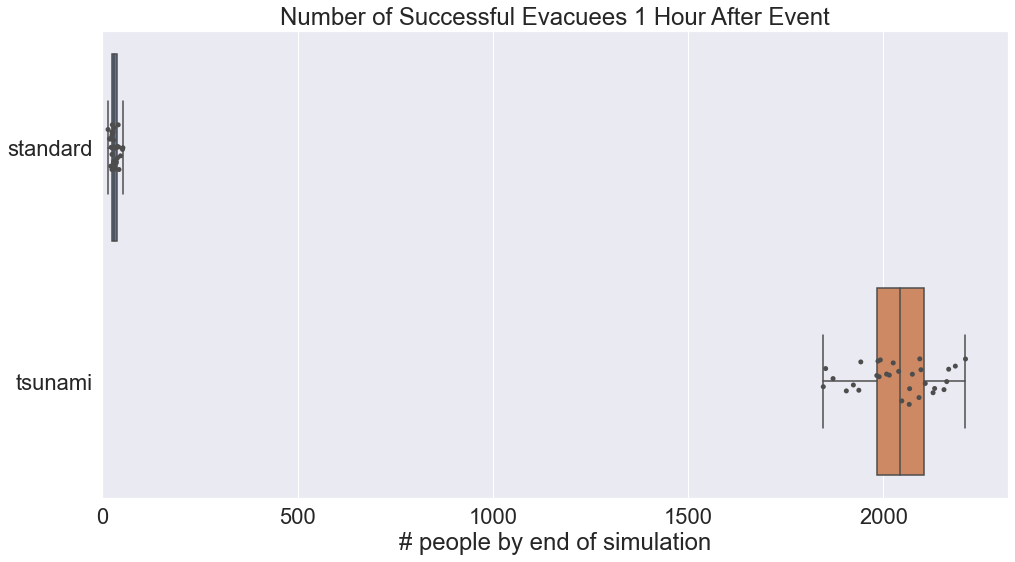

In [93]:
exportCountByScenario(holder, 'ID', "relativeEvacuationCounts.eps", "Number of Successful Evacuees 1 Hour After Event", None, {'status': ['Evacuated']})


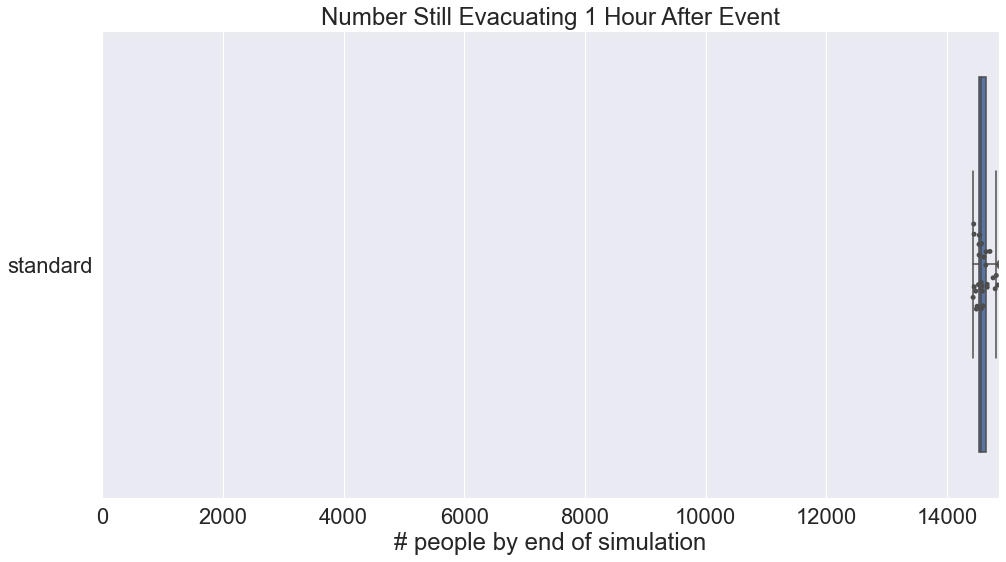

In [96]:
#exportCountByScenario(holder, 'ID', "relativeEvacuationCounts.eps", "Number of Successful Evacuees 1 Hour After Event", None, {'status': ['Evacuated']})
exportCountByScenario(holder, 'ID', "preparing.eps", "Number Still Evacuating 1 Hour After Event", None, {'status': ['TravelToHomeSheltering']})

In [35]:
def exportMapByScenario(df, figureFilename, figureTitle, waterFilename, roadsFilename, 
                        xcolname = 'x_loc', ycolname = 'y_loc',
                       waterFile = None, includeAtts = {}, excludeAtts = {},
                       xlim = [956000, 974000], ylim = [3805000, 3820000]):
    
    # select on appropriate atts
    defaultFlooding = df
    if len(includeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(df, includeAtts, waterFile)
    if len(excludeAtts) > 0: # only select if they exist       
        defaultFlooding = selectOnAttribute(defaultFlooding, selectNonEvacs, exclude=True)
   
    # transform this into spatial data
    gdf = geopandas.GeoDataFrame(defaultFlooding, geometry=geopandas.points_from_xy(
        defaultFlooding[xcolname], defaultFlooding[ycolname]))
    
    # aggregate by the final statuses
    peopleInZone = gdf.groupby(['settings enabled'])#.agg({'ID': 'count'}).reset_index()

    # initialise for the mapping phase
    roads = geopandas.read_file(roadsFilename)
    water = geopandas.read_file(waterFilename)

    # pull out constants to help with plotting
    myIndex = 0
    numPlots = len(peopleInZone)
    nrows = int(numPlots / 2)
    
    # set up the correct number of subplots
    fig, axs = plt.subplots(ncols=2, nrows = int(numPlots / 2), sharex=True, sharey=True, figsize=(15,6 * nrows + 1))

    # iterate through the set of settings and plot them separately
    for a, b in peopleInZone:

        # select the correct axis upon which to plot
        i = myIndex % 2
        j = int(myIndex / 2)

        # just in case there's only the one row and it defaults to a different shape
        if(nrows <= 1):
            ax = axs[i]
        else:
            ax = axs[i, j]


        # plot the background and the people
        roads.plot(ax=ax, edgecolor='#CCCCCC')
        water.plot(ax=ax, color='#AACCFF')
        b.plot(ax=ax, color='red', alpha=.01, zorder=2)

        # set up the title for this section
        ax.set_title(a)

        # zoom to the interesting part
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # add a scalebar
        scalebar = ScaleBar(dx=1, location='lower right')
        ax.add_artist(scalebar)

        # update the very hacky index
        myIndex += 1

    fig.suptitle(figureTitle)

    myFiletype = figureFilename.split('.')[-1]
    if(myFiletype == 'eps'):
        print("WARNING: eps file types don't retain transparency - maybe try png instead?")
    plt.savefig(figureFilename, format=myFiletype, dpi=72)


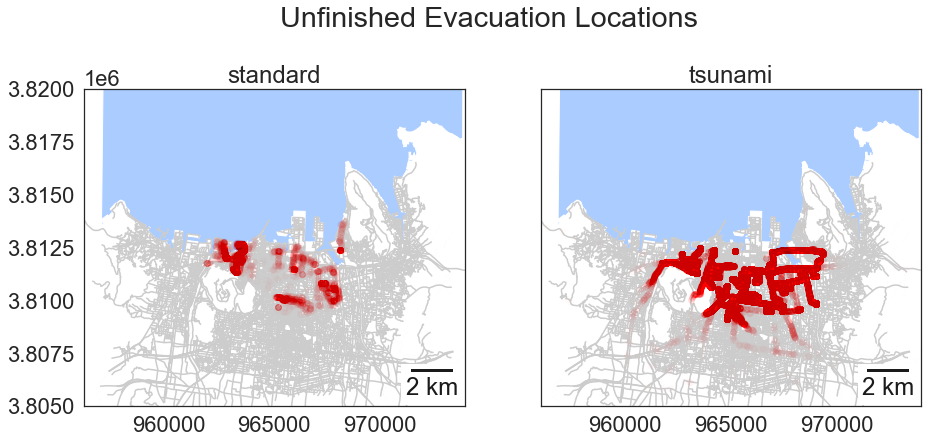

In [72]:
sns.set_style('white')

exportMapByScenario(holder, "stillEvacuating_flooded.png", "Unfinished Evacuation Locations", waterFloodedFile, roadsFile, includeAtts ={'status': ['Evacuating']})

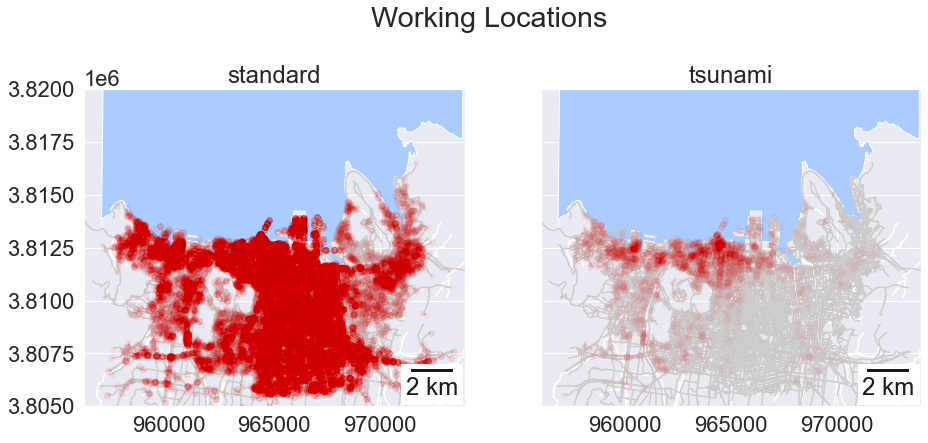

In [75]:
exportMapByScenario(holder, "workingAtEnd.png", "Working Locations", waterFloodedFile, roadsFile, includeAtts ={'status': ['Work']})



In [99]:
def exportMetricByScenario(df, metric, func, figureFilename = "output.png", figureTitle = "Metric By Scenario", waterFile = None,
                          includeAtts = {}):

    # select on appropriate atts
    defaultFlooding = df
    defaultFlooding = selectOnAttribute(defaultFlooding, includeAtts, waterFile)

    # aggregate by the final statuses
    peopleInZone = defaultFlooding.groupby(['seed', 'settings enabled']).agg({metric: func}).reset_index()

    # sizing
    fig = plt.gcf() # extracting the figure information so we can change sizes
    fig.set_size_inches(15, 8) # change the plot size
    sns.set(font_scale=2) # change the font size
    
    # graphs
    sns.boxplot(x=metric, y='settings enabled', data=peopleInZone)
    sns.stripplot(x=metric, y='settings enabled', data=peopleInZone, dodge=True, size=5, color='.3')

    #plt.xscale('log')

    # adjust the layout for better centering
    plt.tight_layout()
    
    # labels
    plt.xlabel(func + " of " + metric + " by end of simulation")
    #plt.xlim((0, max(peopleInZone['ID'])))
    plt.ylabel("")
    plt.title(figureTitle)
    plt.xlim(left=0)

    # extract figure type from end of file
    myFiletype = figureFilename.split('.')[-1]
    plt.savefig(figureFilename, format=myFiletype, dpi=300)

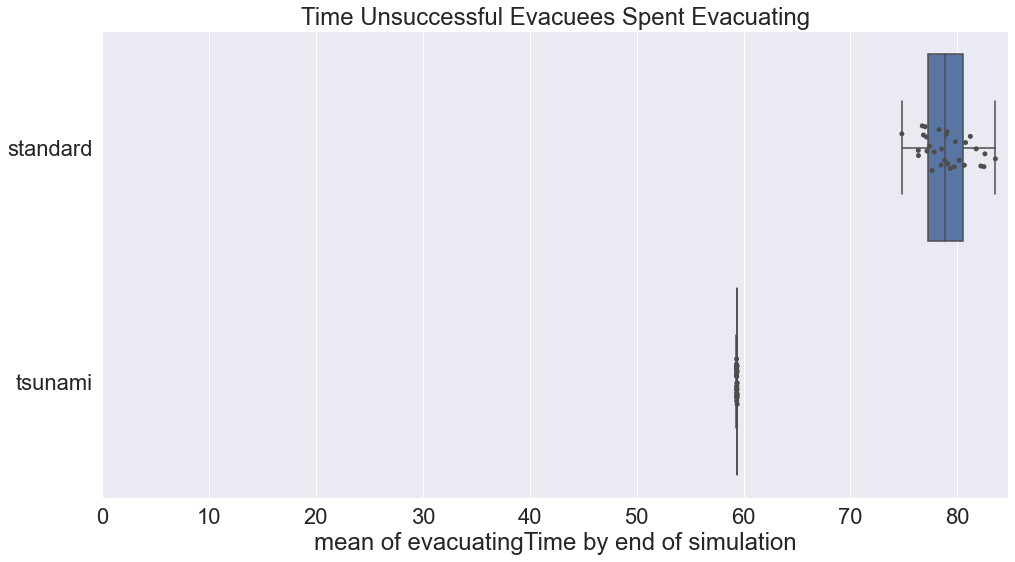

In [100]:
exportMetricByScenario(holder, 'evacuatingTime', 'mean', "evacuatingTime.eps", "Time Unsuccessful Evacuees Spent Evacuating", includeAtts = {'status': ['Evacuating']})



In [102]:
720 / 60.

12.0